# BIOINFO M224 - Project 6: Genotype Imputation

In [23]:
num_snps = 1000 # all snps in file

full.data = read.table('imputation_training.txt', header = TRUE)
data = t(head(full.data,num_snps))

alpha = 2/3 # this factor controls how many SNPs are allowed to cross the threshold

In [24]:
# shitty method: just look at average over everyone, pick the most common one
shitty_impute = data.frame(most_common = apply(data,2,function(x) names(which.max(table(x)))))
    
# super shitty method
ss_impute = data.frame(x= sample(c(0,1,2),replace = TRUE, size = num_snps))

In [25]:
cor_matrix = cor(data[1:100,]) # find the correlation matrix. NOT IDEAL FOR LARGE MATRICES.
diag(cor_matrix) = 0 # set diagonal to 0, so that the actual SNP is never included in the model (that would be cheating)
threshold = apply(abs(cor_matrix),2,max)*alpha # set threshold so that some SNPs always make it
mapping = data.frame(which(abs(cor_matrix) >= threshold, arr.ind = TRUE), row.names = NULL)
map2 = list()
for (i in 1:dim(data)[2]){
    map2[[i]] = mapping$col[mapping$row == i]
}

In [26]:
accuracy = array(data = NA, dim=dim(data)[2])
shitty_accuracy = array(data = NA, dim=dim(data)[2])
ss_accuracy = array(data = NA, dim=dim(data)[2])

for (current_snp in 1:dim(data)[2]){
    x = data[,map2[[current_snp]]]
    y = data[,current_snp]
    m = lm(y~x) # linear model!
    predictions = round(predict(m))
    correct = sum(predictions[100:135] == y[100:135])
    total = length(y[100:135])
    accuracy[current_snp] = correct/total
    
    shitty_correct = sum(shitty_impute[current_snp,] == y)
    shitty_accuracy[current_snp] = shitty_correct/total
    
    ss_correct = sum(ss_impute[current_snp,] == y)
    ss_accuracy[current_snp] = ss_correct/total
}

In [27]:
df = data.frame(accuracy,shitty_accuracy,ss_accuracy)
summary(df)

    accuracy      shitty_accuracy  ss_accuracy    
 Min.   :0.6111   Min.   :1.361   Min.   :0.0000  
 1st Qu.:0.9722   1st Qu.:1.889   1st Qu.:0.4722  
 Median :1.0000   Median :2.528   Median :1.0417  
 Mean   :0.9792   Mean   :2.464   Mean   :1.2860  
 3rd Qu.:1.0000   3rd Qu.:3.000   3rd Qu.:1.9444  
 Max.   :1.0000   Max.   :3.389   Max.   :3.3889  

Warning message:
In hist.default(df$accuracy, 50, plot = FALSE, breaks = breaks): argument ‘freq’ is not made use of

ERROR: Error in hist.default(df$shitty_accuracy, 50, plot = FALSE, breaks = breaks): some 'x' not counted; maybe 'breaks' do not span range of 'x'


ERROR: Error in hist.default(df$ss_accuracy, 50, plot = FALSE, breaks = breaks): some 'x' not counted; maybe 'breaks' do not span range of 'x'


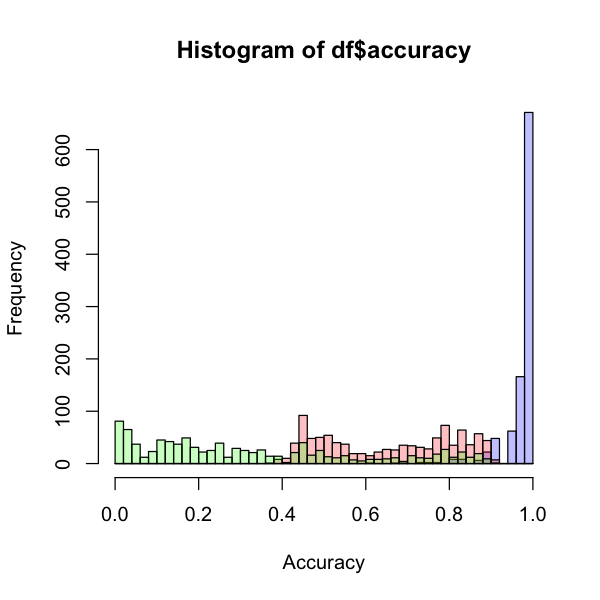

In [28]:
# Plotting the histogram
options(repr.plot.width = 5, repr.plot.height = 5)
breaks = seq(0,1,0.02)
p1 = hist(df$accuracy,50, plot=FALSE, breaks = breaks)
p2 = hist(df$shitty_accuracy,50, plot=FALSE, breaks = breaks)
p3 = hist(df$ss_accuracy,50, plot=FALSE, breaks = breaks)
plot( p1, col=rgb(0,0,1,1/4), xlim=c(0,1), xlab='Accuracy')  # first histogram
plot( p2, col=rgb(1,0,0,1/4), xlim=c(0,1), add=T)
plot( p3, col=rgb(0,1,0,1/4), xlim=c(0,1), add=T)

In [36]:
# The same thing as above, but for multiple (static) thresholds
# so that we can draw a figure
num_snps = 1000 # just looking at first 1000 for computation time reasons
thresholds = (1:10)/10

dff = data.frame()

for(threshold in thresholds){

    full.data = read.table('imputation_training.txt', header = TRUE)
    data = t(head(full.data,num_snps))

    # shitty method: just look at average over everyone, pick the most common one
    shitty_impute = data.frame(most_common = apply(data,2,function(x) names(which.max(table(x)))))

    # super shitty method
    ss_impute = data.frame(x= sample(c(0,1,2),replace = TRUE, size = num_snps))

    cor_matrix = cor(data)[1:100,]
    diag(cor_matrix) = 0

    mapping = data.frame(which(abs(cor_matrix) >= threshold, arr.ind = TRUE), row.names = NULL)
    map2 = list()
    for (i in 1:dim(data)[2]){
        map2[[i]] = mapping$col[mapping$row == i]
    }

    accuracy = array(data = NA, dim=35)
    shitty_accuracy = array(data = NA, dim=35)
    ss_accuracy = array(data = NA, dim=35)

    for (current_snp in 1:dim(data)[2]){
        y = data[,current_snp]

        total = length(y[100:135])
        shitty_correct = sum(shitty_impute[current_snp,] == y[100:135])
        shitty_accuracy[current_snp] = shitty_correct/total

        ss_correct = sum(ss_impute[current_snp,] == y[100:135])
        ss_accuracy[current_snp] = ss_correct/total

        if (length(map2[[current_snp]]) == 0){
            next
        }
        x = data[,map2[[current_snp]]]

        m = lm(y~x)
        predictions = round(predict(m))
        wrong = sum(predictions[100:135] != y[100:135])
        correct = length(y[100:135]) - wrong
        total = sum(!is.na(y[100:135]))
        accuracy[current_snp] = correct/total
    }

    df = data.frame(accuracy,shitty_accuracy,ss_accuracy)
    summary(df)

    acc = accuracy
    acc[is.na(accuracy)] = 1/3

    dff = rbind(dff,data.frame(threshold, mean(acc), mean(shitty_accuracy), mean(ss_accuracy)))
}

dff

,threshold,mean.acc.,mean.shitty_accuracy.,mean.ss_accuracy.
1,0.1000000,0.9983333,0.6569167,0.3310833
2,0.2000000,0.9891667,0.6569167,0.3393333
3,0.3000000,0.9827778,0.6569167,0.3355000
4,0.4000000,0.9630556,0.6569167,0.3388056
5,0.5000000,0.9458333,0.6569167,0.3268056
6,0.6000000,0.9416667,0.6569167,0.3289167
7,0.7000000,0.9238889,0.6569167,0.3238611
8,0.8000000,0.9022222,0.6569167,0.3290833
9,0.9000000,0.8338889,0.6569167,0.3313611
10,1.0000000,0.5733333,0.6569167,0.3251111


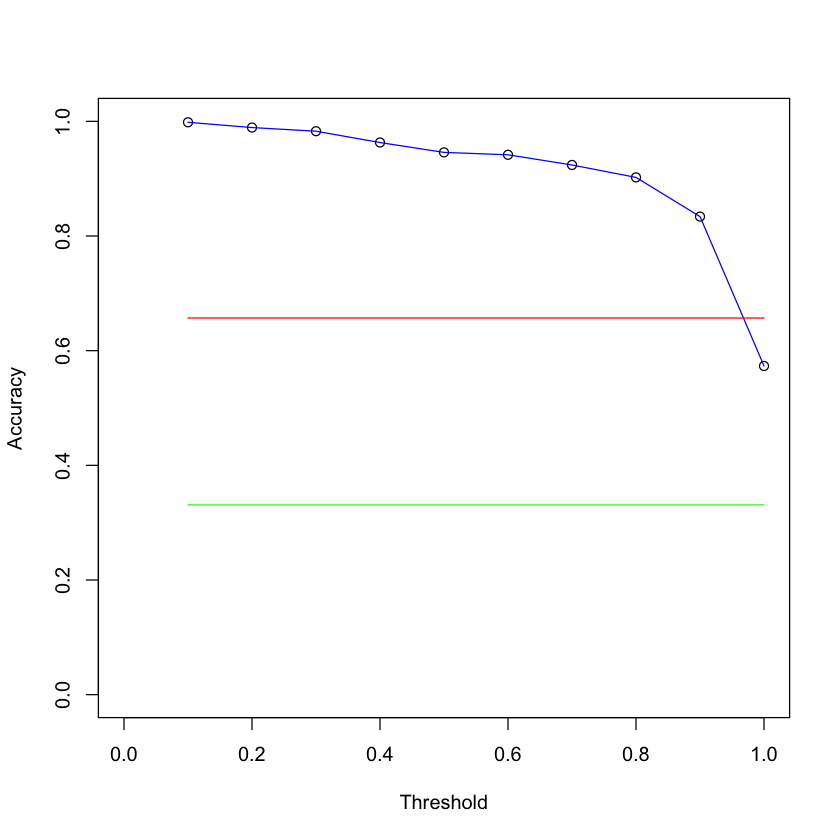

In [37]:
plot(dff$threshold, dff$mean.acc., xlim=c(0,1), ylim=c(0,1), xlab = 'Threshold', ylab = 'Accuracy')
lines(dff$threshold, dff$mean.acc., col='blue')
lines(dff$threshold, dff$mean.shitty_accuracy., col = 'red')
lines(dff$threshold, rep(mean(dff$mean.ss_accuracy.),length(dff$threshold)), col = 'green')

~Fin~